<a href="https://colab.research.google.com/github/basmadokkar/CV/blob/main/UNET_WITH_DATA_(Satellite_Images).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
# !pip install patchify

In [88]:
import random
import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
import glob
import os
import cv2
import tensorflow as tf
from tensorflow.python.client import device_lib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import optimizers
from keras.optimizers import Adam
from keras.metrics import MeanIoU
from keras import backend as K
from sklearn import metrics
from google.colab import drive

from keras.preprocessing.image import ImageDataGenerator
from skimage.filters import threshold_otsu, threshold_multiotsu
from cv2 import adaptiveThreshold

In [89]:
phisycal_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num of GPUs available: ",len(phisycal_devices) )

tf.config.experimental.set_memory_growth(phisycal_devices[0] , True)

Num of GPUs available:  1


In [90]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [91]:
!ls /content/drive/MyDrive/New_data_diff_image/

'adam_777_image_65epoch_diff_img (1).hdf5'   Avarange_intencty	 FUZZY_min_NDBI_DI   onera.zip
 adam_777_image_65epoch_diff_img.hdf5	     diff_img		 mask1
 adam_777_image_65epoch_FUZZY_NDBI_DI.hdf5   Fusion_Fuzzy_min	 NDBI
 adam_777_image_65epoch_Fuzzyset_min.hdf5    Fuzzy_DI_AI_min	 New_Fusion1


In [92]:
%%time
train_images_diff,i = [],0
for directory_path in glob.glob("/content/drive/MyDrive/New_data_diff_image/diff_img"):
    for img_path1 in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        imgs1 = cv2.imread(img_path1, cv2.IMREAD_COLOR)
        imgs1=imgs1.astype('float32')
        train_images_diff.append(imgs1)
#         i += 1
#         if i == 775:
#             break
#Convert list to array for machine learning processing
X1 = np.array(train_images_diff)
X1 = np.expand_dims(X1, -1)
X1 = X1/255.0
X1.shape
# train_images_diff = 0

CPU times: user 1.94 s, sys: 480 ms, total: 2.42 s
Wall time: 9.87 s


(777, 256, 256, 3, 1)

In [93]:
i

0

In [94]:
%%time
train_mask = []
J=0
for directory_path in glob.glob("/content/drive/MyDrive/New_data_diff_image/mask1"):
    for mask_path in sorted(glob.glob(os.path.join(directory_path, "*.png"))):
        #print(mask_path)
        mask = cv2.imread(mask_path)
        mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask_gray=mask_gray.astype('float32')
        # print(mask_gray.shape)
        # plt.imshow(mask_gray)
        train_mask.append(mask_gray)
        # J += 1
        # if J == 775:
        #     break
#Convert list to array for machine learning processing

Y= np.array(train_mask)
train_mask= 0
#Y =Y.reshape((6000,256,256,1))
Y = np.expand_dims(Y, -1)
Y = Y/255.0
Y.shape

CPU times: user 767 ms, sys: 390 ms, total: 1.16 s
Wall time: 6.81 s


(777, 256, 256, 1)

In [95]:
print("Pixel values in the mask are: ", np.unique(Y))

Pixel values in the mask are:  [0. 1.]


In [96]:
X_train, X_test, y_train, y_test = train_test_split(X1, Y, test_size = 0.25, random_state = 0)
print(X_train.shape)
print(X_test.shape)

(582, 256, 256, 3, 1)
(195, 256, 256, 3, 1)


In [97]:
IMG_HEIGHT = X1.shape[1]
IMG_WIDTH  = X1.shape[2]
IMG_CHANNELS = X1.shape[3]

kernel_initializer =  'he_uniform'  # also try 'he_normal' but model not converging...
################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    def recall_m(y_train, y_pred):
        true_positives = K.sum(K.round(K.clip(y_train * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_train, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision_m(y_train, y_pred):
        true_positives = K.sum(K.round(K.clip(y_train * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    def f1_m(y_train, y_pred):
        precision = precision_m(y_train, y_pred)
        recall = recall_m(y_train, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

    model.summary()

    return model

In [98]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [99]:
# weights = model.get_weights()
# A =[]

# for w in weights :
#     if len(np.array(w).shape) == 1 and len(np.array (w)) == 1:
#        A.append(w)
#     else:
#         F = w.flatten()
#         for f in F :
#             A.append(f)

In [100]:
# np.quantile(np.array(A),0.75)

In [101]:
# (np.array(A)).flatten()

557


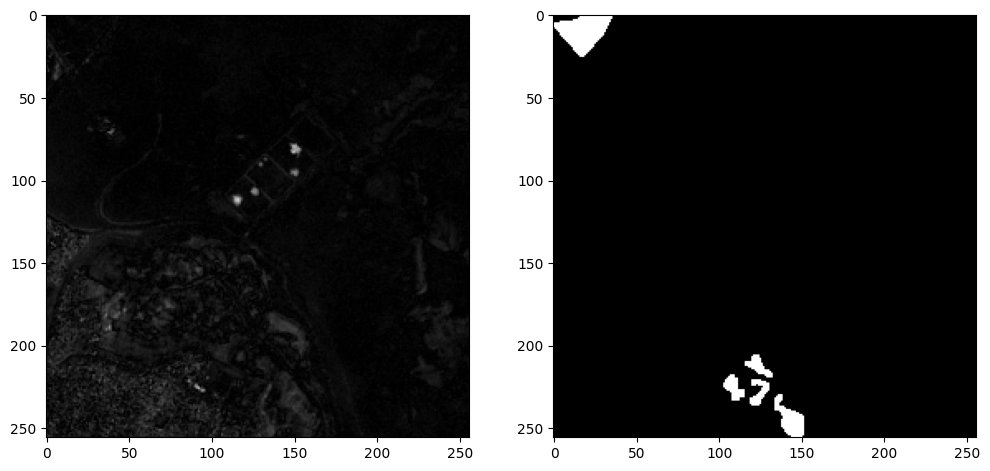

In [102]:
image_number = random.randint(0, len(X_train))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256,3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

In [103]:


%%time
seed=24

img_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.5,
                     fill_mode='reflect',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.
X_train=X_train.reshape(582, 256, 256, 3)
X_test=X_test.reshape(195, 256, 256, 3)
image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_data_generator.fit(X_train, augment=True, seed=seed)
image_generator = image_data_generator.flow(X_train, seed=seed)
valid_img_generator = image_data_generator.flow(X_test, seed=seed)

CPU times: user 7.92 s, sys: 315 ms, total: 8.23 s
Wall time: 8.28 s


In [104]:
%%time

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_data_generator.fit(y_train, augment=True, seed=seed)
mask_generator = mask_data_generator.flow(y_train, seed=seed)
valid_mask_generator = mask_data_generator.flow(y_test, seed=seed)

CPU times: user 2.54 s, sys: 108 ms, total: 2.65 s
Wall time: 2.68 s


In [105]:
def my_image_mask_generator(image_generator, mask_generator):
    train_generator = zip(image_generator, mask_generator)
    for (img, mask) in train_generator:
        yield (img, mask)

my_generator = my_image_mask_generator(image_generator, mask_generator)

validation_datagen = my_image_mask_generator(valid_img_generator, valid_mask_generator)



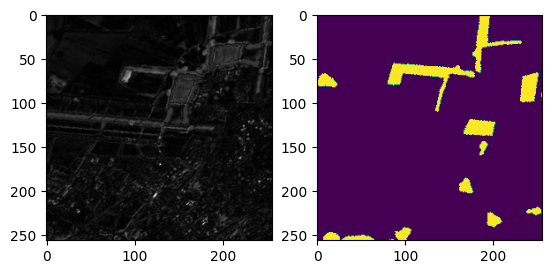

In [106]:
x = image_generator.next()
y = mask_generator.next()
for i in range(0,1):
    image = x[i]
    mask = y[i]
    plt.subplot(1,2,1)
    plt.imshow(image[:,:,0], cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(mask[:,:,0])
    plt.show()

In [107]:
10**-3

0.001

In [108]:


%%time
model = get_model()
from tensorflow import keras
#@title Select parameters {run: "auto"}

optimizer = 'adam' #@param ["adam" , "momentum" , "rmsprop" , "adagrad", "nag"] {type :"string"}
Learning_rate = 0.0001 #@param {type:"number"}
LR = float(Learning_rate)
if (optimizer=="adagrad"):
  opt = keras.optimizers.Adagrad(learning_rate=LR)
if (optimizer=="adam"):
  opt = keras.optimizers.Adam(learning_rate=LR)
if (optimizer=="RMSprop"):
  opt = keras.optimizers.RMSProp(learning_rate=LR)
if (optimizer=="momentum"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9)
if (optimizer=="nag"):
  opt = keras.optimizers.SGD(learning_rate=LR,momentum=0.9,nesterov=True)

batch_size = 64
steps_per_epoch = 3*(len(X_train))//batch_size
model.compile(optimizer= opt, loss='binary_crossentropy', metrics=['acc'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
history = model.fit(my_generator,
                    validation_data = validation_datagen,
                    steps_per_epoch = steps_per_epoch,
                    validation_steps = steps_per_epoch,
                    epochs=300)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

KeyboardInterrupt: 

In [109]:
#plot the training and validation accuracy and loss at each epoch
# batch_size*steps_per_epoch*len(loss)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
# test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
print(test_img_number)
prediction = model.predict(test_img_input)
prediction = prediction> threshold_otsu(prediction)
prediction=prediction[0,:,:,0]
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

In [ ]:
# Hystersis thresholding
# def hystersis_threshold(img,t,T):
#     img[img<t], img[img>=T]= 0,255
#     for row in range(1,img.shape[0]-1):
#         for col in range(1,img.shape[1]-1):
#             n_size = 3
#             neib = img[row:row+n_size,col:col+n_size]
#             if((img[row+int(n_size/2),col+int(n_size/2)]>=t)&(img[row+int(n_size/2),col+int(n_size/2)]<T)):
#                 if (True in np.unique(neib>=T,return_counts=True)[0]):
#                     img[row+int(n_size/2),col+int(n_size/2)] = 255
#                 elif(True in np.unique((neib>=t)&(neib<T),return_counts=True)[0]):
#                     neib = img[row:row+n_size+2,col:col+n_size+2]
#                     if (True in np.unique(neib>=T,return_counts=True)[0]):
#                         img[row+int(n_size/2),col+int(n_size/2)] = 255
#                     else:
#                         img[row+int(n_size/2),col+int(n_size/2)] = 0
#     return img

In [ ]:
list(X_test)[0].shape

In [ ]:
pred,y_pred = [model.predict(np.expand_dims(xt,0)) for xt in list(X_test)],[]
for p in pred:
  t = p[p>0.1].mean()
  p[p<t],p[p>=t] = 0, 1
  y_pred.append(p)


In [ ]:
y_test_metrics = np.array([np.ravel(yt) for yt in y_test])
y_pred_metrics = np.array([np.ravel(yp) for yp in y_pred])

In [ ]:
y_pred[0]

In [ ]:
plt.imshow(np.squeeze(y_pred[0]),cmap='gray')

In [ ]:
plt.imshow(np.squeeze(y_test[0]),cmap='gray')

In [ ]:
# y_pred = model.predict(X_test)
# t,T = y_pred[y_pred>0.1].mean(),y_pred[y_pred>0.3].mean()
# y_test_metrics = np.array([np.ravel(yt) for yt in y_test])
# y_pred_metrics  = np.array([np.ravel(hystersis_threshold(yp,t,T)) for yp in y_pred])

In [ ]:
metrics.precision_recall_fscore_support(y_test_metrics,y_pred_metrics,average = 'macro')

In [ ]:
metrics.matthews_corrcoef(y_test_metrics,y_pred_metrics)